# Causal Inference

## Do Why

In [2]:
! pip install dowhy
! pip install graphviz

     |████████████████████████████████| 152 kB 3.2 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import dowhy.api
from matplotlib import pyplot as plt
import seaborn as sns

### Import Training Dataset

In [63]:
train_data = pd.read_csv("../Data/Fraud_train.csv")
train_data.drop("Unnamed: 0",axis=1 ,inplace=True)

In [26]:
train_data.head(5)

,MonthOfAccident,WeekOfMonthOfAccident,MonthClaimed,WeekOfMonthClaimed,AgeOfPolicyHolder,RepNumber,Deductible,DriverRating,PoliceReportFiled,WitnessPresent,Year,DayOfWeekOfAccident,Make,AccidentArea,DayOfWeekClaimed,Sex,MaritalStatus,Fault,PolicyType,VehicleCategory,VehiclePriceRange,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeRangeOfPolicyHolder,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy,FraudFound_P
0,-1.259959,0.168525,-1.254102,0.245174,-0.080811,-0.533756,-0.174155,-0.437815,-0.171366,-0.074494,0.165709,4.0,6.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,2.0,0.0,7.0,5.0,0.0,0.0,0.0,2.0,1.0,0
1,-0.397055,-0.610084,-0.390117,-0.548153,1.780973,0.550819,-0.174155,-0.437815,-0.171366,-0.074494,1.408929,2.0,17.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,2.0,1.0,7.0,7.0,0.0,1.0,0.0,0.0,1.0,0
2,1.616388,-1.388694,1.625847,-0.548153,-1.295018,1.418479,-0.174155,0.453743,-0.171366,-0.074494,-1.077512,3.0,17.0,1.0,6.0,1.0,1.0,0.0,2.0,1.0,1.0,4.0,2.0,2.0,4.0,3.0,0.0,2.0,0.0,0.0,2.0,0
3,-0.684689,-1.388694,-0.678112,-1.341479,-0.971229,-0.967586,-0.174155,0.453743,-0.171366,-0.074494,-1.077512,7.0,9.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0,2.0,0.0,5.0,4.0,0.0,3.0,0.0,0.0,1.0,0
4,-0.972324,0.947134,-0.966107,1.038500,1.052449,0.116989,-0.174155,0.453743,-0.171366,-0.074494,-1.077512,4.0,3.0,1.0,6.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,7.0,6.0,0.0,1.0,0.0,0.0,1.0,0


### Check correlation of input variables with Outcome: FraudFound_P

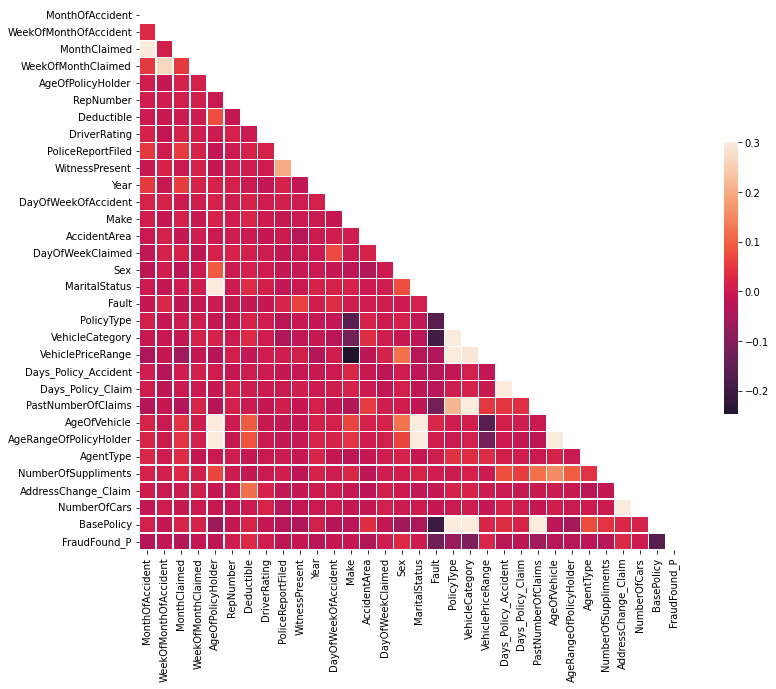

In [27]:
# Let's viualize the corr between independent variables and with dependant (target variable)
plt.figure(figsize=(15,10))
#sns.heatmap(train_data.corr(), annot=True, cmap="Set2")
#ax = sns.heatmap(train_data.corr(), cmap="YlGnBu")
# creating mask
corr = train_data.corr()
mask = np.triu(np.ones_like(corr))
# plotting a triangle correlation heatmap
#dataplot = sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True, mask=mask)
dataplot = sns.heatmap(corr, mask=mask, cmap="rocket", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 


In [61]:
train_data.columns

Index(['MonthOfAccident', 'WeekOfMonthOfAccident', 'MonthClaimed',
       'WeekOfMonthClaimed', 'AgeOfPolicyHolder', 'RepNumber', 'Deductible',
       'DriverRating', 'PoliceReportFiled', 'WitnessPresent', 'Year',
       'DayOfWeekOfAccident', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePriceRange', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeRangeOfPolicyHolder',
       'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim',
       'NumberOfCars', 'BasePolicy', 'FraudFound_P'],
      dtype='object')

### Create Causal Model ,  Identify Effect, Estimate Effect

In [62]:
causal_graph = """digraph {
PolicyType -> FraudFound_P;
VehiclePriceRange -> FraudFound_P;
Make -> VehiclePriceRange;
VehicleCategory -> PolicyType;
BasePolicy -> PolicyType
Fault -> DriverRating;
DriverRating -> FraudFound_P;
NumberOfCars -> VehiclePriceRange;
NumberOfCars -> FraudFound_P
AgeOfPolicyHolder -> DriverRating;
AgeOfVehicle -> PastNumberOfClaims;
PastNumberOfClaims -> Fault;
AgeOfPolicyHolder -> PoliceReportFiled;
Fault -> FraudFound_P;
AgentType -> FraudFound_P;
PoliceReportFiled -> FraudFound_P;
PastNumberOfClaims -> FraudFound_P;
AccidentArea -> FraudFound_P;
}"""

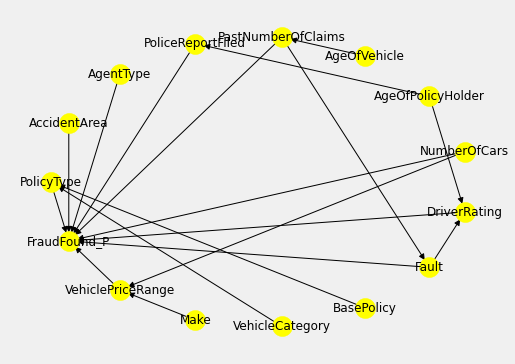

In [63]:
model= CausalModel(
        data=train_data,
        treatment=['VehicleCategory'],
        outcome=['FraudFound_P'],
        graph = causal_graph.replace("\n", " "),
        common_causes= [ 'AgeOfPolicyHolder', 'DriverRating', 'PoliceReportFiled', 
        'Make', 'AccidentArea','Fault', 'PolicyType', 
       'VehiclePriceRange', 'PastNumberOfClaims', 'AgeOfVehicle', 
       'AgentType','NumberOfCars', 'BasePolicy'])
model.view_model(layout="dot")

In [64]:
#Here is the causal model
import dowhy
from dowhy import CausalModel

cols = [ 'VehicleCategory','AgeOfPolicyHolder', 'DriverRating', 'PoliceReportFiled', 
        'Make', 'AccidentArea','Fault', 'PolicyType', 
       'VehiclePriceRange', 'PastNumberOfClaims', 'AgeOfVehicle', 
       'AgentType','NumberOfCars', 'BasePolicy']
X = train_data[cols]
effects = dict()
test = dict()
estimand= dict()

for i in X:
    print("Treatment Variable: ",i)
    model = CausalModel(data = train_data,
                        treatment = i,
                        outcome = 'FraudFound_P',
                        graph = causal_graph.replace("\n", " "),
                        common_causes = list(X.drop(i, axis = 'columns').columns))
    #model.view_model(layout="dot")
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                    test_significance = True)
    
    effects[i] = estimate.value
    test[i] = estimate
    estimand[i]=identified_estimand

Treatment Variable:  VehicleCategory
Treatment Variable:  AgeOfPolicyHolder
Treatment Variable:  DriverRating
Treatment Variable:  PoliceReportFiled
Treatment Variable:  Make
Treatment Variable:  AccidentArea
Treatment Variable:  Fault
Treatment Variable:  PolicyType
Treatment Variable:  VehiclePriceRange
Treatment Variable:  PastNumberOfClaims
Treatment Variable:  AgeOfVehicle
Treatment Variable:  AgentType
Treatment Variable:  NumberOfCars
Treatment Variable:  BasePolicy


In [72]:
#piecing together the dataframes and also processing out the p-values (brute force)
estimates = pd.DataFrame(effects.items(),columns=['Feature', 'Estimate'])
tests = pd.DataFrame(test.items(), columns=['Feature', 'P-Values'])
tests = tests.astype(str)
tests['P-Values'] = tests['P-Values'].str.split('p-value: ').str[-1]
tests['P-Values'] = tests['P-Values'].str.replace(r'[', '')
tests['P-Values'] = tests['P-Values'].str.replace(r']\n', '')
tests['P-Values'] = tests['P-Values'].str.split('###').str[0]
tests = tests.astype({"P-Values": float})
tests['Estimate'] = estimates['Estimate']
finaldf = tests.round(4).sort_values('Estimate')

### Summarize Estimates

In [73]:
finaldf.sort_values('P-Values')

,Feature,P-Values,Estimate
6,Fault,0.0000,-0.0704
7,PolicyType,0.0000,-0.0371
4,Make,0.0000,-0.0007
8,VehiclePriceRange,0.0000,0.0022
9,PastNumberOfClaims,0.0001,-0.0034
5,AccidentArea,0.0046,-0.0270
13,BasePolicy,0.0299,-0.0419
10,AgeOfVehicle,0.0435,-0.0044
3,PoliceReportFiled,0.0852,-0.0047
1,AgeOfPolicyHolder,0.4293,-0.0042


In [74]:
#features with high causal inference
high_evd = finaldf[finaldf['P-Values'] <= 0.05]
high_evd.sort_values('P-Values')

,Feature,P-Values,Estimate
6,Fault,0.0000,-0.0704
7,PolicyType,0.0000,-0.0371
4,Make,0.0000,-0.0007
8,VehiclePriceRange,0.0000,0.0022
9,PastNumberOfClaims,0.0001,-0.0034
5,AccidentArea,0.0046,-0.0270
13,BasePolicy,0.0299,-0.0419
10,AgeOfVehicle,0.0435,-0.0044


In [75]:
#features with low causal inference
low_evd = finaldf[finaldf['P-Values'] >= 0.05]
low_evd

,Feature,P-Values,Estimate
0,VehicleCategory,0.8559,-0.0369
11,AgentType,0.6664,-0.0198
3,PoliceReportFiled,0.0852,-0.0047
1,AgeOfPolicyHolder,0.4293,-0.0042
12,NumberOfCars,0.4339,0.0006
2,DriverRating,0.6419,0.0011


## CausalML

In [38]:
! pip install causalml

     |████████████████████████████████| 401 kB 4.0 MB/s 
     |████████████████████████████████| 326 kB 39.5 MB/s 
     |████████████████████████████████| 1.8 MB 44.5 MB/s 
     |████████████████████████████████| 713 kB 39.9 MB/s 
  Created wheel for causalml: filename=causalml-0.12.1-cp37-cp37m-linux_x86_64.whl size=1036198 sha256=3bd0e9e4b04c42a9e9e68f9fd6fa7c3ecfcef3749a506b32c031bd580c7db8f7
  Stored in directory: /root/.cache/pip/wheels/c2/a7/ff/f853b7e4d8d4d9b68df70333a06d6a01fd96fb086e2922ace1
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465089 sha256=7e52c7a64dfd284acfff22603aafd8668e19626a2cbe506193a67cc3b99ad32d
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [47]:

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [39]:
train_data[cols]

,VehicleCategory,AgeOfPolicyHolder,DriverRating,PoliceReportFiled,Make,AccidentArea,Fault,PolicyType,VehiclePriceRange,PastNumberOfClaims,AgeOfVehicle,AgentType,NumberOfCars,BasePolicy
0,0.0,-0.080811,-0.437815,-0.171366,6.0,1.0,0.0,1.0,1.0,0.0,7.0,0.0,2.0,1.0
1,0.0,1.780973,-0.437815,-0.171366,17.0,1.0,1.0,1.0,1.0,1.0,7.0,0.0,0.0,1.0
2,1.0,-1.295018,0.453743,-0.171366,17.0,1.0,0.0,2.0,1.0,2.0,4.0,0.0,0.0,2.0
3,0.0,-0.971229,0.453743,-0.171366,9.0,1.0,0.0,1.0,1.0,0.0,5.0,0.0,0.0,1.0
4,0.0,1.052449,0.453743,-0.171366,3.0,1.0,1.0,1.0,2.0,1.0,7.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10686,0.0,1.295291,1.345301,-0.171366,6.0,1.0,1.0,0.0,1.0,1.0,6.0,0.0,0.0,0.0
10687,2.0,0.485819,0.453743,-0.171366,2.0,1.0,0.0,6.0,5.0,2.0,6.0,0.0,2.0,0.0
10688,1.0,0.971502,-0.437815,-0.171366,2.0,0.0,0.0,2.0,1.0,0.0,6.0,0.0,0.0,2.0
10689,0.0,-0.809335,0.453743,-0.171366,6.0,1.0,1.0,1.0,1.0,2.0,4.0,0.0,0.0,1.0


### Effect of Treatment Variable "BasePolicy" on target variable FraudFound_P

In [83]:
cols = [ 'VehicleCategory','AgeOfPolicyHolder', 'DriverRating', 'PoliceReportFiled', 
        'Make', 'AccidentArea','Fault', 'PolicyType', 
       'VehiclePriceRange', 'PastNumberOfClaims', 'AgeOfVehicle', 
       'AgentType','NumberOfCars']
treatment = ['treatment' if x == 0 else 'control' for x in train_data['BasePolicy']]
top_balanced=train_data[cols]

In [84]:

cols

['VehicleCategory',
 'AgeOfPolicyHolder',
 'DriverRating',
 'PoliceReportFiled',
 'Make',
 'AccidentArea',
 'Fault',
 'PolicyType',
 'VehiclePriceRange',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgentType',
 'NumberOfCars']

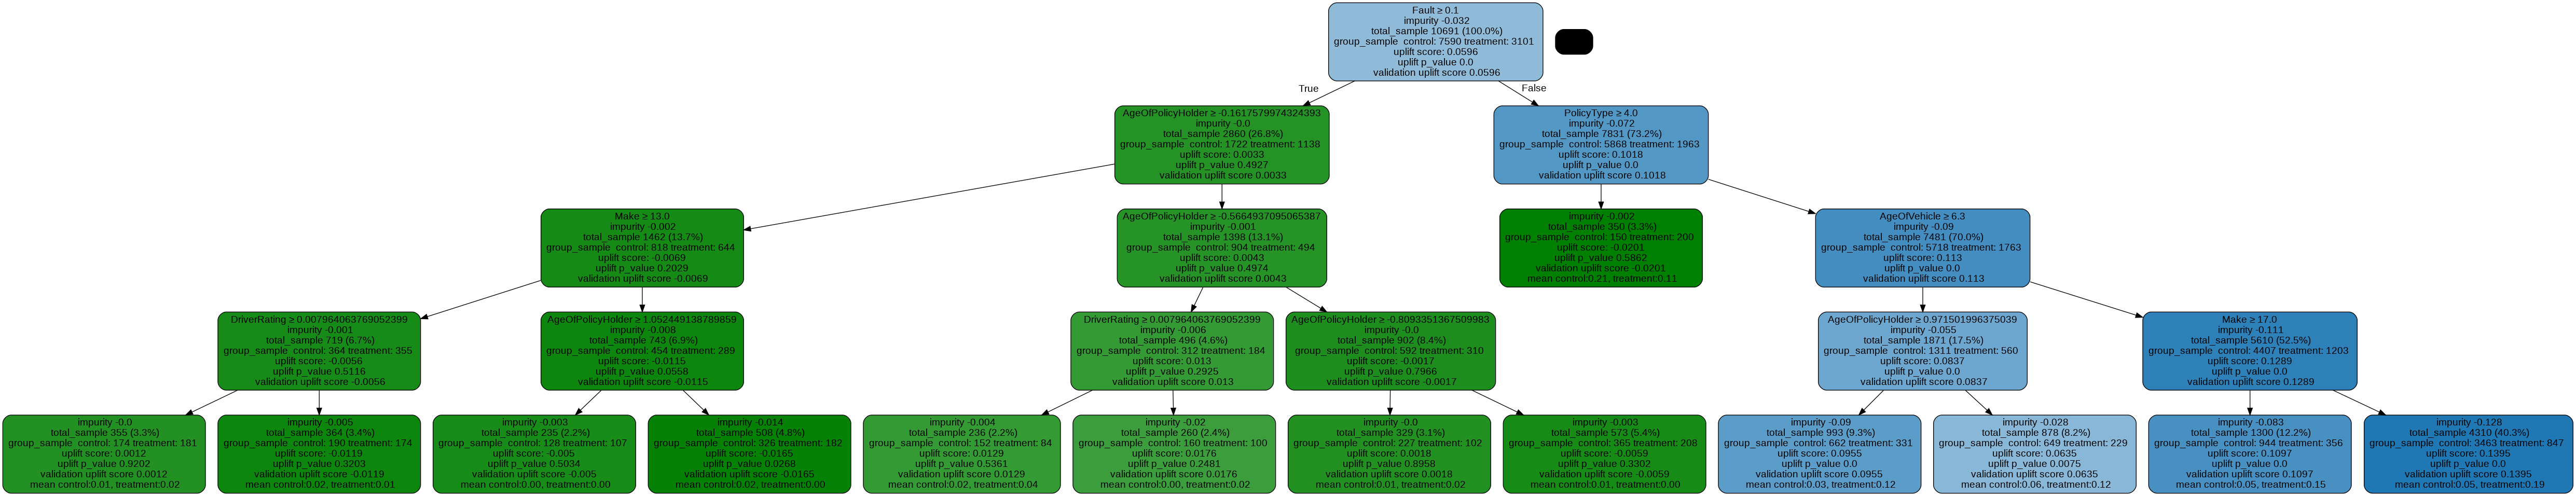

In [85]:

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
y, X, treatment = train_data["FraudFound_P"],top_balanced[cols],np.array(treatment)

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X,
                 treatment=treatment,
                 y=y)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
Image(graph.create_png())

In [86]:
result = uplift_tree_string(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
result

Fault >= 0.1?
yes -> AgeOfPolicyHolder >= -0.1617579974324393?
		yes -> Make >= 13.0?
				yes -> DriverRating >= 0.007964063769052399?
						yes -> [0.011494252873563218, 0.016574585635359115]
						no  -> [0.021052631578947368, 0.005747126436781609]
				no  -> AgeOfPolicyHolder >= 1.052449138789859?
						yes -> [0.0, 0.0]
						no  -> [0.018404907975460124, 0.0]
		no  -> AgeOfPolicyHolder >= -0.5664937095065387?
				yes -> DriverRating >= 0.007964063769052399?
						yes -> [0.019736842105263157, 0.03571428571428571]
						no  -> [0.0, 0.02]
				no  -> AgeOfPolicyHolder >= -0.8093351367509983?
						yes -> [0.013215859030837005, 0.0196078431372549]
						no  -> [0.00821917808219178, 0.0]
no  -> PolicyType >= 4.0?
		yes -> [0.20666666666666667, 0.11]
		no  -> AgeOfVehicle >= 6.3?
				yes -> AgeOfPolicyHolder >= 0.971501996375039?
						yes -> [0.027190332326283987, 0.12386706948640483]
						no  -> [0.06317411402157165, 0.1222707423580786]
				no  -> Make >= 17.0?
						yes -> [0.04978

In [87]:

from causalml.inference.meta import BaseXClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#Propensity Model
prop_model = LGBMClassifier(colsample_bytree=0.8, subsample = 0.8, n_estimators=300)
print(cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean())
#model achieves AUC of 0.57, which makes it useful in evaluating the test outcome

#Fitting the model
prop_model.fit(X, treatment)

#Getting propensity scores
prop_scores = prop_model.predict_proba(X)


learner_x = BaseXClassifier(LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(), control_name='control')

#Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])
print(ate_x, ate_x_lb, ate_x_ub)

1.0
[0.06400689] [0.05809607] [0.0699177]


Text(0.5, 1.0, 'Feature Importance - T-Learner')

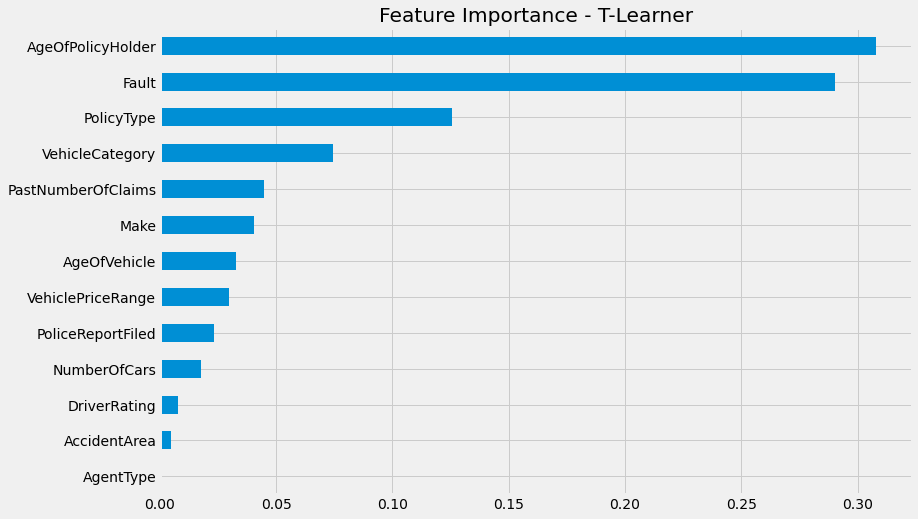

In [93]:
model_tau = XGBRegressor(importance_type='gain', verbosity=0)

#T-Learner
tlearner = BaseTRegressor(XGBRegressor(verbosity = 0), control_name='control')
tlearner.estimate_ate(X, treatment, y)
tlearner_tau = tlearner.fit_predict(X, treatment, y)
#tlearner.get_importance(X=X, tau=tlearner_tau, 
#                        normalize=True, method='auto', features=X_vars)

#Plot features importance
tlearner.plot_importance(X=X, tau=tlearner_tau, normalize=True, method='auto', features=cols)
plt.title('Feature Importance - T-Learner')

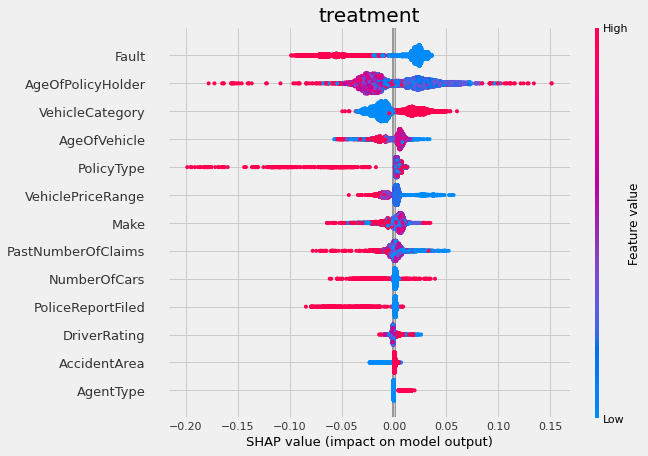

In [94]:
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=cols)